In [2]:
# default_exp historical_bt

In [30]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl

from scipy.stats import norm, moment

%matplotlib inline
mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16, 6

In [4]:
# export

import pandas as pd
import numpy as np
import logging
from mlbt.load_data import DATA_DIR

SYMBOLS_F = pd.read_csv(DATA_DIR / "symbols.csv", index_col="iqsymbol")
SLIPPAGE_ESTIMATE = 0.25  # We estimate we'll pay 1/4 of the bid-ask spread
COMMISSION_ESTIMATE = 1 

def simulate_pnl(close, signal, pos_size=50000, pos_cap_multi=500):
    pos_cap = pos_size * pos_cap_multi
    volatility = np.log(close).diff().ewm(com=32 * 25).std()
    prices = (np.log(close).diff() / volatility).cumsum()

    currency_pos = (pos_size * signal / volatility).clip(-pos_cap, pos_cap)
    profit = (close.pct_change() * currency_pos.shift(periods=1)).sum(axis=1)
    s_nav, s_nav_wo_costs, s_Profit, s_Profit_wo_costs, stats = estimate_trading_costs(
        close, currency_pos, profit
    )

    return s_nav, s_nav_wo_costs, stats


def estimate_trading_costs(prices, currency_pos, profits, init_capital=7e7):
    # TODO: This code is old and needs refactoring
    # Do copies to shapes of prices dataframe and allow for easy multiplication later
    multipliers = prices.copy()
    for col in multipliers.columns:
        multipliers[col] = SYMBOLS_F.loc[col, "multiplier"]

    tick_sizes = prices.copy()
    for col in tick_sizes.columns:
        tick_sizes[col] = SYMBOLS_F.loc[col, "mintick"]

    commissions = pd.DataFrame(COMMISSION_ESTIMATE, index=prices.index, columns=prices.columns)

    num_contracts = currency_pos.div(multipliers.mul(prices)).round(0)

    contracts_traded = num_contracts.diff().abs()
    slippage = contracts_traded.mul(tick_sizes.mul(multipliers)) * SLIPPAGE_ESTIMATE
    commissions_cost = contracts_traded.mul(commissions)
    trading_costs = commissions_cost + slippage
    daily_trading_costs = trading_costs.fillna(0).sum(axis=1)
    profits_with_costs = profits - daily_trading_costs

    nav_without_costs = (1 + profits / init_capital).cumprod()
    nav_with_costs = (1 + (profits_with_costs) / init_capital).cumprod()
    trade_count = contracts_traded.astype(bool).astype(float).sum().sum()

    stats = {
        "trade_count": trade_count.sum().sum(),
        "contracts_traded": contracts_traded.sum().sum(),
        "total_trading_costs": daily_trading_costs.sum(),
        "commissions_cost": commissions_cost.sum(axis=1).sum(),
        "slippage": slippage.sum(axis=1).sum(),
    }

    return nav_with_costs, nav_without_costs, profits_with_costs, profits, stats

In [5]:
###

In [96]:
import json

fn = 'payload_agriculture-currency-energy-equity_index-interest_rate-metals_dollar_fixed_horizon_10_none_[]_random_forest.json'
p_j = json.load(open(DATA_DIR / 'payloads' / fn))
pay_j = p_j


In [100]:
del p_j['primary']['hyper_params']['class_weight']

In [101]:
json.dump(p_j, open(DATA_DIR / 'payloads' / fn, 'w'))

In [19]:

def get_config(payload, fn):
    if "config" in payload:
        return payload["config"]

    # bridge to the old payload format
    if "fixed_horizon" in fn:
        return {
            "binarize": "fixed_horizon",
            "binarize_params": int(re.findall(r"fixed_horizon_(\d+)", fn)[0]),
        }
    return {}

In [7]:
###

In [91]:
from mlbt.pnl_sim import get_pnl_reports

def simulate_pnl(close, signal, pos_size=50000, pos_cap_multi=500):
    pos_cap = pos_size * pos_cap_multi
    volatility = np.log(close).diff().ewm(com=32 * 25).std()
    prices = (np.log(close).diff() / volatility).cumsum()

    currency_pos = (pos_size * signal / volatility).clip(-pos_cap, pos_cap)
    profit = (close.pct_change() * currency_pos.shift(periods=1)).sum(axis=1)
    s_nav, s_nav_wo_costs, s_Profit, s_Profit_wo_costs, stats = estimate_trading_costs(
        close, currency_pos, profit
    )

    return s_nav, s_nav_wo_costs, stats

file_name = fn

events = pd.DataFrame.from_dict(pay_j["events"])
events = events.set_index(pd.to_datetime(events.index))
events["t1"] = pd.to_datetime(events["t1"])
config = get_config(pay_j, file_name)


closes, clf_signals, alpha_signals = get_pnl_reports(
    events,
    pay_j["symbols"],
    config["binarize"],
    config["binarize_params"],
)

close = closes
report_type = 'primary'
pos_size = 5000
# alpha_signals = (alpha_signals + 1) / 2
# clf_signals = (clf_signals + 1) / 2
logging.info(f"Creating {report_type} tearsheet for {file_name}")

mod_alpha_signals = alpha_signals * clf_signals.abs().expanding().mean()
primary, primary_wo_costs, cost_stats = simulate_pnl(close, mod_alpha_signals, pos_size)
secondary, secondary_wo_costs, cost_stats = simulate_pnl(close, clf_signals, pos_size)


In [92]:
alpha_signals.abs().mean().mean()

1.0

In [93]:
mod_alpha_signals.abs().mean().mean()

0.4148398854312334

In [94]:
clf_signals.abs().mean().mean()

0.4120332472771566

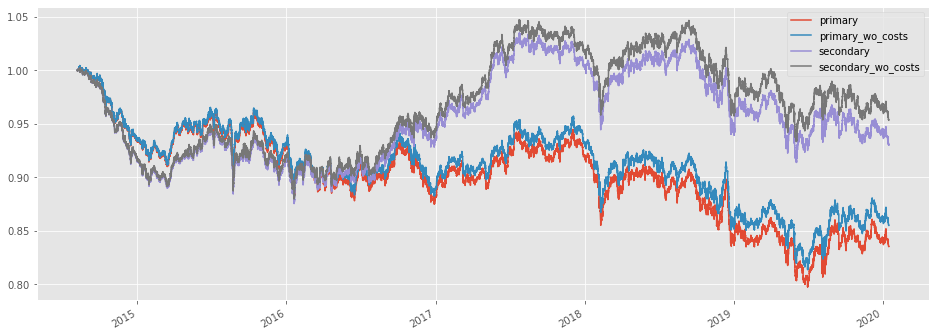

In [95]:
pd.DataFrame({
    'primary':primary,
    'primary_wo_costs':primary_wo_costs,
    'secondary':secondary,
    'secondary_wo_costs':secondary_wo_costs,
}).plot()

In [67]:
# (signal != 0).sum().sort_values()

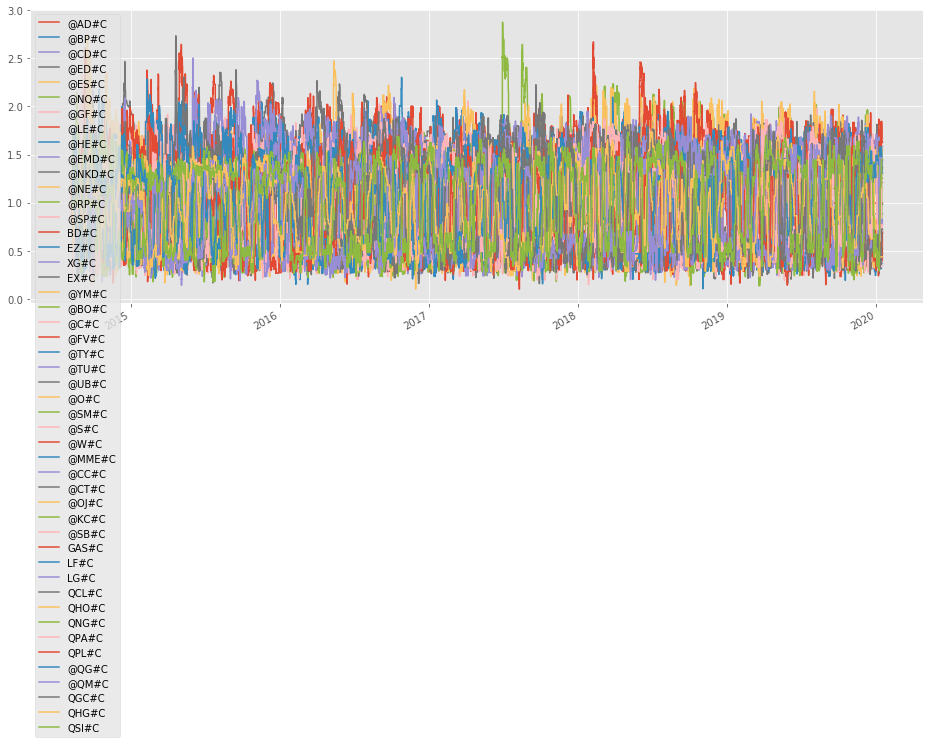

In [63]:
clf_signals.plot()

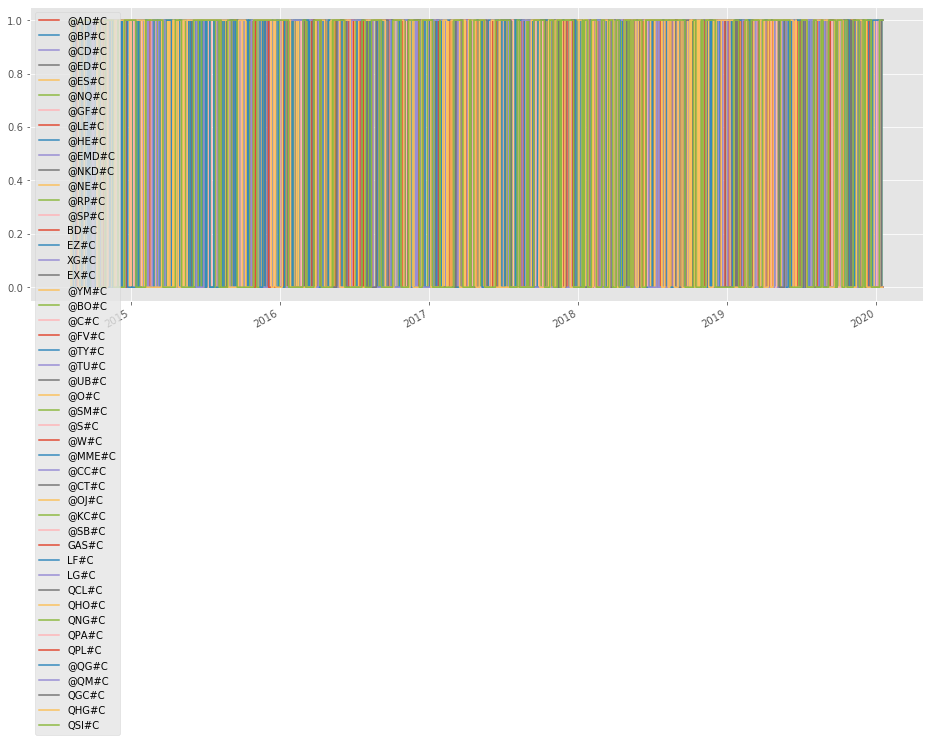

In [77]:
alpha_signals.plot()